In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Medical MNIST - X Ray image classification
### Dataset
https://www.kaggle.com/andrewmvd/medical-mnist 

### Prerequisite
Download the dataset mentioned above and unzip it in `./data/medical_mnist` directory.

### Authors: IAU students in 2021 (bonus assignment)
### References 
- https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15<BR>
- https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2<BR>
- https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_convolutional_neuralnetwork/<BR>
- https://www.kaggle.com/frostnt/medical-mnist-pytorch<BR>

# 1st step: Exploratory Data Analysis
Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations [2].

In [ ]:
!pip install scikit-image

In [1]:
import numpy as np
import pandas as pd
import os, os.path
from keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage import io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
#print classes of images
data_dir = './data/medical_mnist'
classes = os.listdir(data_dir)
print(classes)

['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


In [3]:
#observe the shape of images
io.imread("./data/medical_mnist/AbdomenCT/000000.jpeg").shape

(64, 64)

In [4]:
# number of images in directories and total length of dateset
print('number of images in AbdomenCT: ' + str(len(os.listdir(data_dir+'/AbdomenCT'))))
print('number of images in BreastMRI: ' + str(len(os.listdir(data_dir+'/BreastMRI'))))
print('number of images in ChestCT: ' + str(len(os.listdir(data_dir+'/ChestCT'))))
print('number of images in CXR: ' + str(len(os.listdir(data_dir+'/CXR'))))
print('number of images in Hand: ' + str(len(os.listdir(data_dir+'/Hand'))))
print('number of images in HeadCT: ' + str(len(os.listdir(data_dir+'/HeadCT'))))
print('total length of dataset: ' + str(len(os.listdir(data_dir+'/AbdomenCT')) + len(os.listdir(data_dir+'/BreastMRI')) + 
                                        len(os.listdir(data_dir+'/ChestCT')) + len(os.listdir(data_dir+'/CXR')) +
                                       len(os.listdir(data_dir+'/Hand')) + len(os.listdir(data_dir+'/HeadCT'))))


number of images in AbdomenCT: 10000
number of images in BreastMRI: 8954
number of images in ChestCT: 10000
number of images in CXR: 10000
number of images in Hand: 10000
number of images in HeadCT: 10000
total length of dataset: 58954


***
First we look at some images from each class for better understanding

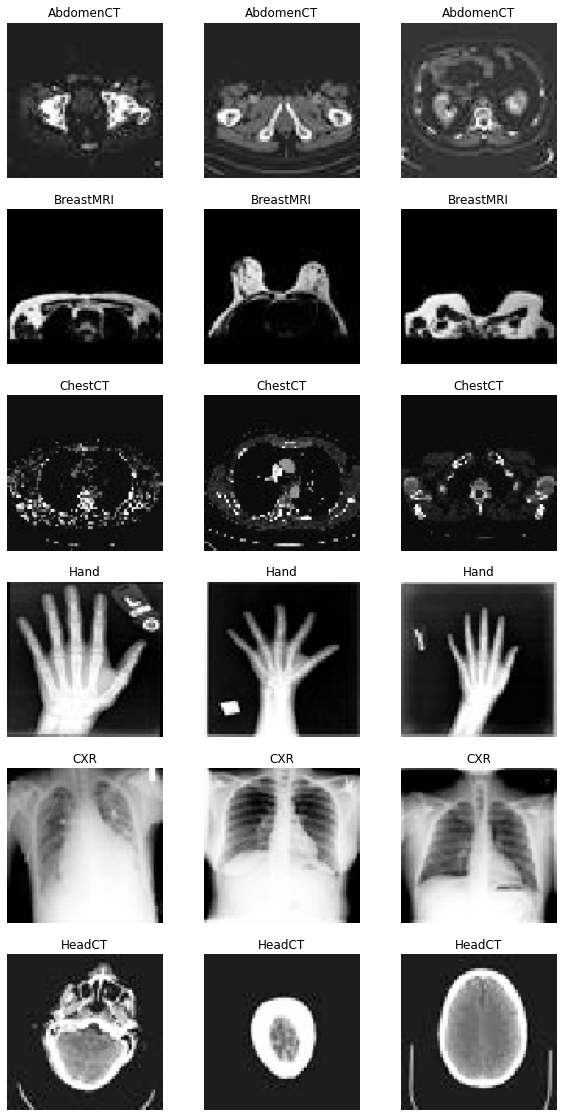

In [5]:
# get the list of jpegs from sub image class folders
AbdomenCT_imgs = [fn for fn in os.listdir(f'{data_dir}/AbdomenCT') if fn.endswith('.jpeg')]
BreastMRI_imgs = [fn for fn in os.listdir(f'{data_dir}/BreastMRI') if fn.endswith('.jpeg')]
ChestCT_imgs = [fn for fn in os.listdir(f'{data_dir}/ChestCT') if fn.endswith('.jpeg')]
CXR_imgs = [fn for fn in os.listdir(f'{data_dir}/CXR') if fn.endswith('.jpeg')]
Hand_imgs = [fn for fn in os.listdir(f'{data_dir}/Hand') if fn.endswith('.jpeg')]
HeadCT_imgs = [fn for fn in os.listdir(f'{data_dir}/HeadCT') if fn.endswith('.jpeg')]

# randomly select 3 from each class
select_AbdomenCT_imgs = np.random.choice(AbdomenCT_imgs, 3, replace = False)
select_BreastMRI_imgs = np.random.choice(BreastMRI_imgs, 3, replace = False)
select_ChestCT_imgs = np.random.choice(ChestCT_imgs, 3, replace = False)
select_CXR_imgs = np.random.choice(CXR_imgs, 3, replace = False)
select_Hand_imgs = np.random.choice(Hand_imgs, 3, replace = False)
select_HeadCT_imgs = np.random.choice(HeadCT_imgs, 3, replace = False)

# plotting all images in a 6x3 plot
fig = plt.figure(figsize = (10,20))
for i in range(18):
    if i < 3:
        fp = f'{data_dir}/AbdomenCT/{select_AbdomenCT_imgs[i]}'
        label = 'AbdomenCT'
    elif i >= 3 and i < 6:
        fp = f'{data_dir}/BreastMRI/{select_BreastMRI_imgs[i-3]}'
        label = 'BreastMRI'
    elif i >= 6 and i < 9:
        fp = f'{data_dir}/ChestCT/{select_ChestCT_imgs[i-6]}'
        label = 'ChestCT'
    elif i >= 9 and i < 12:
        fp = f'{data_dir}/Hand/{select_CXR_imgs[i-9]}'
        label = 'Hand'
    elif i >= 12 and i < 15:
        fp = f'{data_dir}/CXR/{select_Hand_imgs[i-12]}'
        label = 'CXR'
    else:
        fp = f'{data_dir}/HeadCT/{select_HeadCT_imgs[i-15]}'
        label = 'HeadCT'
    ax = fig.add_subplot(6, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
    
plt.show()

If we want to analyze the images further, it is a good idea to convert it into np.array as many is a better representation of images for machine learning.

In [6]:
# defined image size from img.shape
IMAGE_SIZE = 64

# making n X m matrix [3]
def img2np(path, list_of_filename, size = (IMAGE_SIZE, IMAGE_SIZE)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # convert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# randomly select 1000 images from each class to speed up the process
select_AbdomenCT_imgs = np.random.choice(AbdomenCT_imgs, 1000, replace = False)
select_BreastMRI_imgs = np.random.choice(BreastMRI_imgs, 1000, replace = False)
select_ChestCT_imgs = np.random.choice(ChestCT_imgs, 1000, replace = False)
select_CXR_imgs = np.random.choice(CXR_imgs, 1000, replace = False)
select_Hand_imgs = np.random.choice(Hand_imgs, 1000, replace = False)
select_HeadCT_imgs = np.random.choice(HeadCT_imgs, 1000, replace = False)

# run the conversion to np.array on image folders
AbdomenCT_imges = img2np(f'{data_dir}/AbdomenCT/', select_AbdomenCT_imgs)
BreastMRI_imges = img2np(f'{data_dir}/BreastMRI/', select_BreastMRI_imgs)
ChestCT_imges = img2np(f'{data_dir}/ChestCT/', select_ChestCT_imgs)
CXR_imges = img2np(f'{data_dir}/CXR/', select_CXR_imgs)
Hand_imges = img2np(f'{data_dir}/Hand/', select_Hand_imgs)
HeadCT_imges = img2np(f'{data_dir}/HeadCT/', select_HeadCT_imgs)

***
Now we can print an average image of each class, to do that we can take the average value of each pixel across all observations.

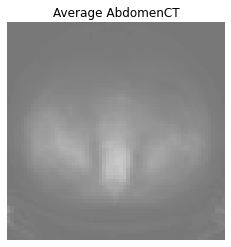

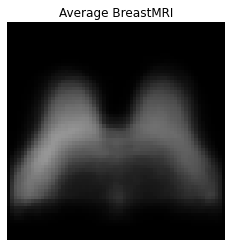

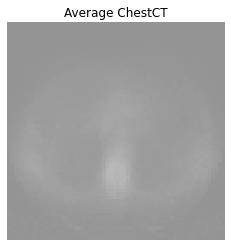

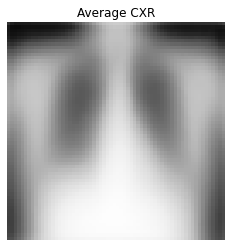

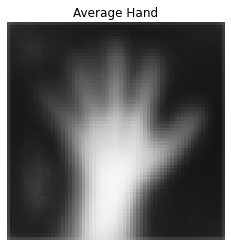

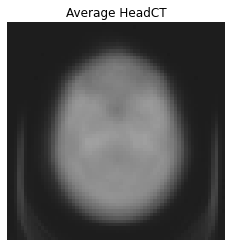

In [7]:
def mean_img(img, title, size = (IMAGE_SIZE, IMAGE_SIZE)):
    # calculate the average from pixels
    mean_img = np.mean(img, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    # plot the image
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

AbdomenCT_mean = mean_img(AbdomenCT_imges, 'AbdomenCT')
BreastMRI_mean = mean_img(BreastMRI_imges, 'BreastMRI')
ChestCT_mean = mean_img(ChestCT_imges, 'ChestCT')
CXR_mean = mean_img(CXR_imges, 'CXR')
Hand_mean = mean_img(Hand_imges, 'Hand')
HeadCT_mean = mean_img(HeadCT_imges, 'HeadCT')

dict_of_means = {'AbdomenCT': AbdomenCT_mean, 
        'BreastMRI': BreastMRI_mean,
        'ChestCT': ChestCT_mean,
        'CXR': CXR_mean, 
        'Hand': Hand_mean,
        'HeadCT': HeadCT_mean
       } 

Now we can observe the difference between mean images, representing the whole class.

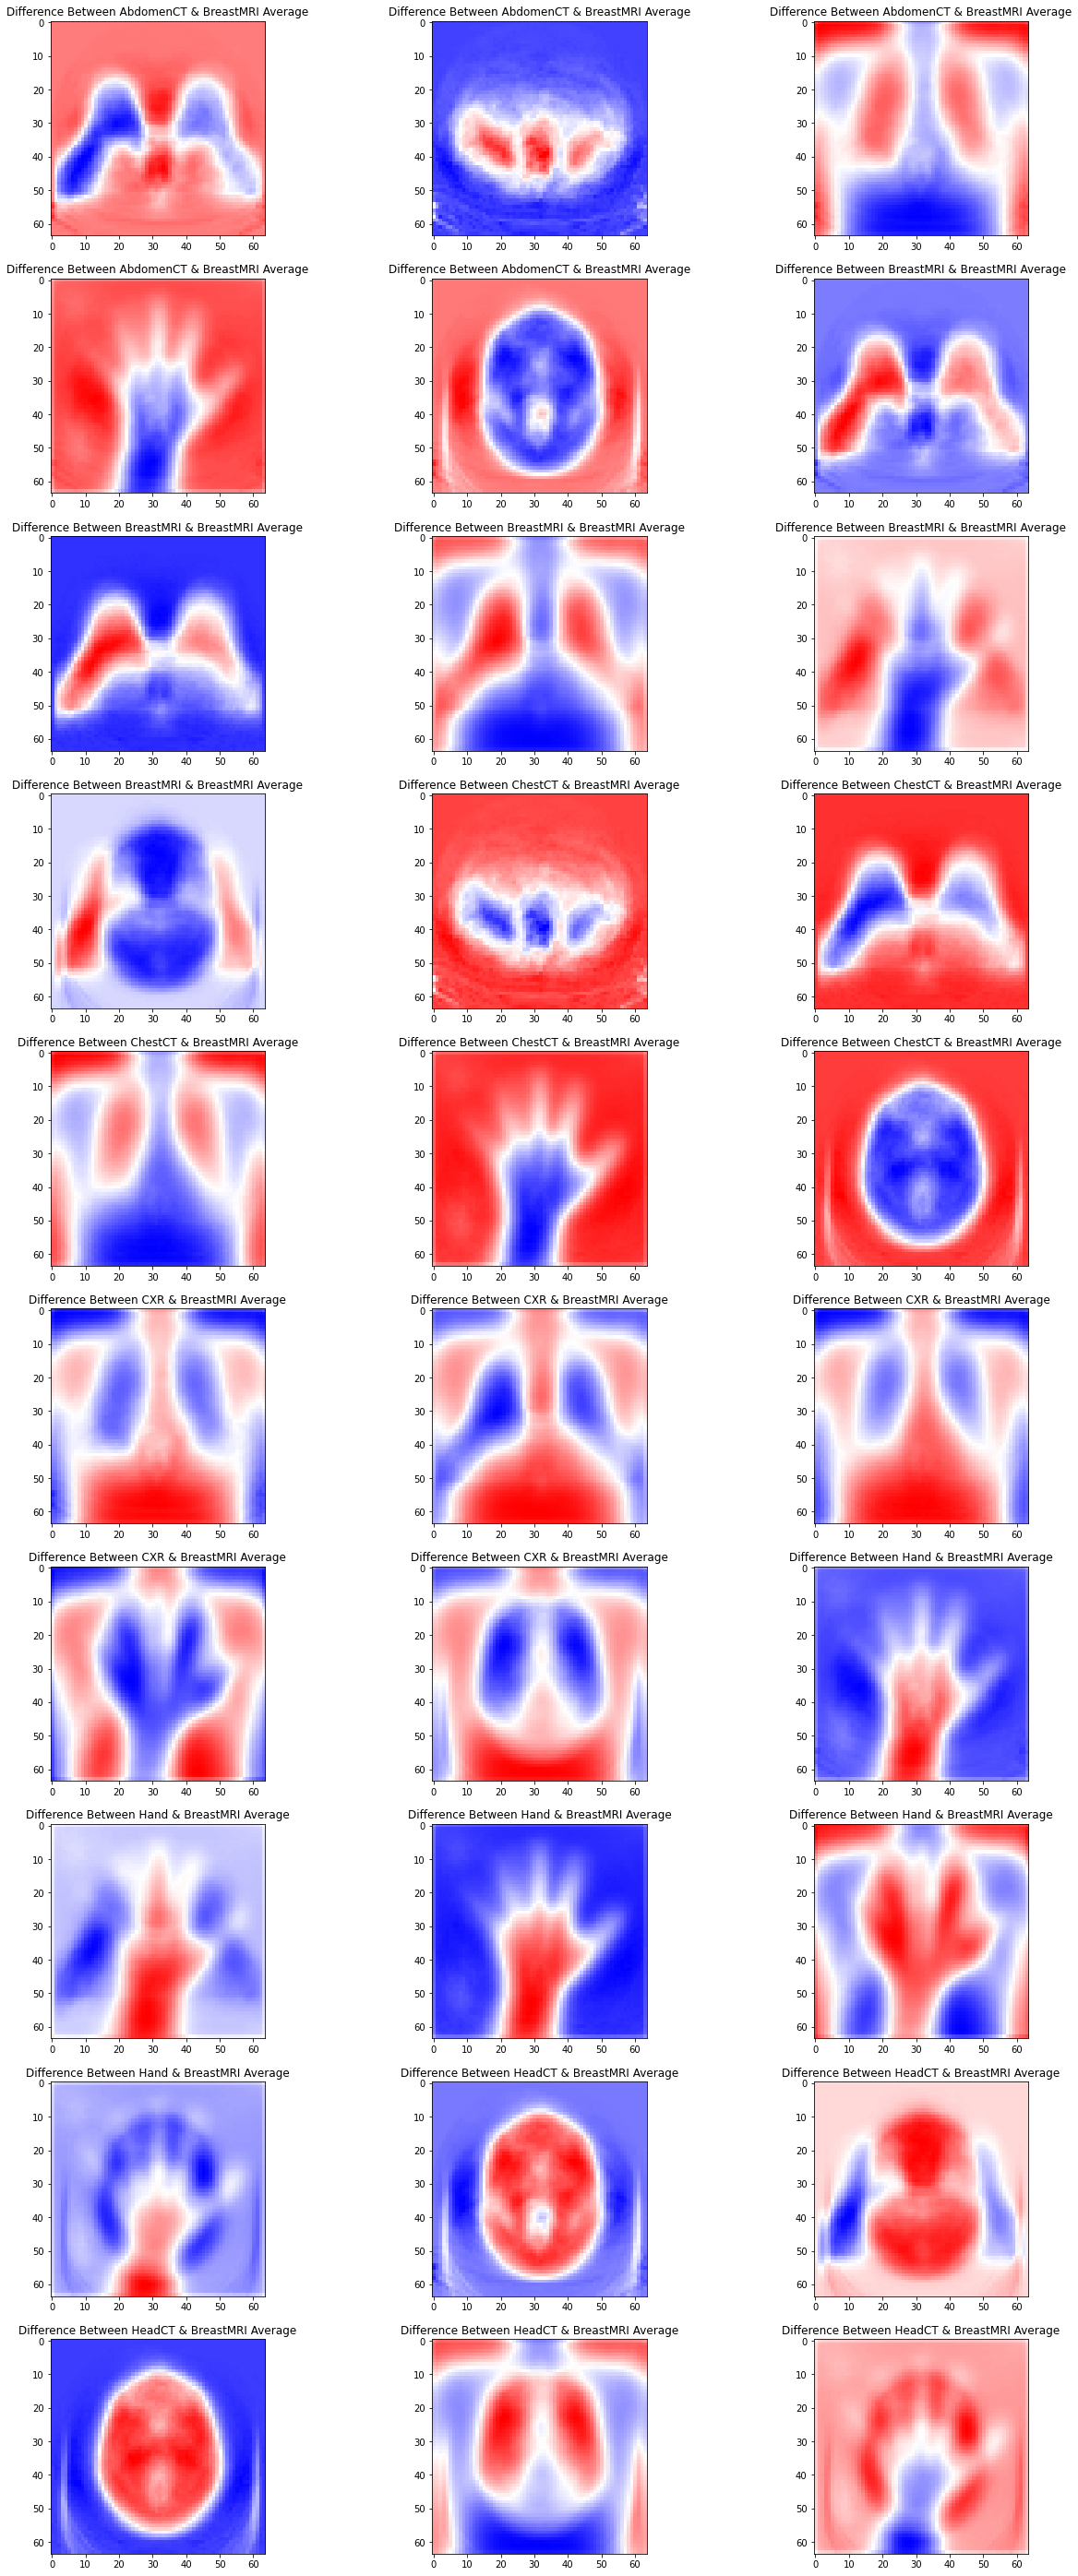

In [8]:
fig = plt.figure(figsize=(21, 50.5))
columns = 3
rows = 10
i = 1
for key1, value1 in dict_of_means.items():
    for key2, value2 in dict_of_means.items():
        if key1 == key2:
            continue
        contrast_mean = value1 - value2
        fig.add_subplot(rows, columns, i)
        plt.imshow(contrast_mean, cmap='bwr')
        plt.title('Difference Between ' + key1 + ' & BreastMRI Average')
        i = i + 1
plt.show()

As we can see, all classes differ significantly from each other in the intensity of pixels in different regions in the image. Classes also contain different types of edges and shapes. CNN is able to learn these features and so we decided to choose it for the classification task.

# 2nd step: Modeling

In [9]:
%pip install torch
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


***
As a first step, we defined the CNN architecture with its layers. We also implement drop out for regularization with probability (0.25) described in Chapter 3.3.4. CNN architectures are described in detail in bachelor thesis in Chapter 3.4, and also described convolution principle, MaxPool and fully connected layers in Chapter 3.4 [1]. 

The forward function is used to pass the input vector through the network and calculate the loss function.
CNN class inspired by architecture in [4].

In [10]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.lin1 = nn.Linear(3136, 64)
        self.lin2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return x

***
Selection of hyperparameters is crucial for CNN. I tested multiple combinations of batch_size, num_epochs with different values ​​of learning rate. Because my computer is quite old and has a weaker CPU, neural network training and success evaluation took almost an hour, which severely limited my ability to test the network for a large number of hyperparameter combinations.

***We achieved the best result on parameters defined below***

In [11]:
# As we don't have Nvidia GPU unit, we only use a CPU version
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
in_channels = 1
num_classes = 6 #number of classes
lr = 0.001 #learning rate - determine the size of step in gradient descent 
batch_size = 60 #number of images in one batch/mini-batch
num_epochs = 8 #number of epochs 

In [12]:
#Loading the dataset
#Inspired by loading function in [5]

class MedicalMNIST(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df #classes of images
        self.root_dir = root_dir #setting root dir
        self.transform = transform 
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0]) #get path to the image
        image = io.imread(img_path) #read image
        y_label = torch.tensor(int(self.annotations.iloc[index, 1])) #label for image
        
        if self.transform:
            image = self.transform(image) #tansform dataframe
        
        return (image, y_label) #return image with assigned label

In [13]:
#load path to images with assigned labels into the dataframe

mp = {}
df = []
for idx, category in enumerate(os.listdir("./data/medical_mnist")):
    mp[category] = idx
    for image in os.listdir("./data/medical_mnist/"+category):
        df.append([category+"/"+image, mp[category]])
df = np.array(df)
df = pd.DataFrame(df)
df.head()

,0,1
0,AbdomenCT/000000.jpeg,0
1,AbdomenCT/000001.jpeg,0
2,AbdomenCT/000002.jpeg,0
3,AbdomenCT/000003.jpeg,0
4,AbdomenCT/000004.jpeg,0


In [14]:
dataset = MedicalMNIST(df=df, root_dir="./data/medical_mnist",
                       transform=transforms.ToTensor())

In [15]:
# train_set, test_set = torch.utils.data.random_split(dataset,
#                                                    [48954,10000])

In [16]:
# split dataset on train and test subset
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=1)

In [17]:
# load the data from subsets into the batches
train_loader = DataLoader(train_set, batch_size=(batch_size), shuffle=True)
test_loader = DataLoader(test_set, batch_size=(batch_size), shuffle=True)

In [18]:
# create CNN model
model = CNN(in_channels, num_classes).to(device)

# Loss
criterion = nn.CrossEntropyLoss()

From optimizers, we decided to use Adam (adaptive momentum) since nowadays it is mostly used optimizer. It combines RMSProp with momentum and bias correction, which adjusts the deviations at the start of the algorithm and speeds up the convergence [1].

In [19]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [20]:
# examination of parameters
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[[[ 0.1603,  0.2539, -0.2173],
          [ 0.2743,  0.2980,  0.0786],
          [ 0.2486, -0.2775,  0.1111]]],


        [[[ 0.0340,  0.1500,  0.1931],
          [ 0.1688,  0.1666,  0.2150],
          [-0.2329, -0.0641, -0.1273]]],


        [[[ 0.0806,  0.1130,  0.3057],
          [-0.0435, -0.2983, -0.1082],
          [ 0.1497, -0.2519,  0.0638]]],


        [[[-0.1707, -0.0925,  0.0811],
          [-0.0485, -0.2528,  0.2172],
          [-0.0796, -0.0251, -0.3053]]],


        [[[-0.2768, -0.0748,  0.1945],
          [ 0.2115,  0.1368,  0.0531],
          [ 0.2170, -0.2387,  0.2925]]],


        [[[ 0.2136,  0.1003, -0.1735],
          [ 0.2305, -0.1400, -0.0855],
          [ 0.2803,  0.2177,  0.1091]]],


        [[[-0.2760,  0.1635,  0.3025],
          [-0.1753, -0.1473,  0.2629],
          [-0.0138,  0.1459, -0.0528]]],


        [[[-0.1004, -0.2111,  0.1278],
          [-0.0927, -0.3218, -0.0590],
          [-0.2633,  0.0057, -0.0043]]],


        [[

In [21]:
import matplotlib.pyplot as plt

def my_plot(epochs, loss):
    plt.plot(epochs, loss)

We train the network on a training subset of data.

In [22]:
# Function for training the network for number of epochs
# Inspired by the training function in [5]

def train(model, num_epochs):
    loss_vals=  []
    for epoch in range(num_epochs):
        epoch_loss= []
        for batch, (data, targets) in enumerate(train_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            #Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            
            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            epoch_loss.append(loss.item())
            
            # Gradient descent
            optimizer.step()
            
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print(epoch, "Current Loss:", loss)
    return loss_vals
            
loss_vals = train(model, num_epochs)

0 Current Loss: tensor(0.0003, grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.3868e-05, grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(2.4000e-05, grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(0.0001, grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.3431e-05, grad_fn=<NllLossBackward0>)
5 Current Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward0>)
6 Current Loss: tensor(3.9736e-08, grad_fn=<NllLossBackward0>)
7 Current Loss: tensor(2.7418e-06, grad_fn=<NllLossBackward0>)


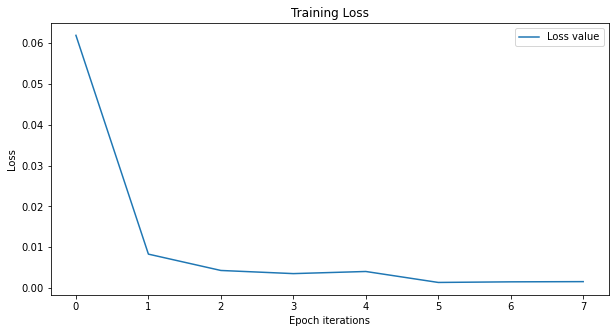

In [23]:
# visualization of loss during the training

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(loss_vals,label="Loss value")
plt.xlabel("Epoch iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Finally we evaluate the accuracy on train and test subset of data.

In [24]:
# function for evaluation of the model
# Inspired by the training function in [5]

def evaluate(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, pred = scores.max(1)
            correct += (pred == y).sum()
            total += pred.size(0)
        print("Accuracy:", correct/total*100, "%")
    
evaluate(train_loader, model)
evaluate(test_loader, model)

Accuracy: tensor(99.9534) %
Accuracy: tensor(99.8558) %


Our model was able to learn good sights on the training data and achieve high accuracy on testing subset, specifically accuracy was ***99.8558%***.